# Section 1 : Libraries and Data
## Section 1.1 : Importing Libraries 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Section 1.2 : Getting preprocessed data
Note : For the preliminary regression analysis to give a good starting heuristic, I have used the differenced case shiller index (effectively rate of change in case shiller index).

In [ ]:
# Demand
demand = pd.read_csv('demand/demand_data_full.csv',index_col='observation_date')
demand.columns = ["d_"+col for col in demand.columns]

# Supply 
supply = pd.read_csv('supply/supply_data_full.csv',index_col='observation_date')
supply.columns = ["s_"+col for col in supply.columns]

# Label
csi = pd.read_csv('case_shiller_index.csv',index_col='observation_date')
csi_dec_99 = 99.8490
csi_arr = np.insert(csi['case_schiller_index'].to_numpy(),0,csi_dec_99)
csi_rate = (csi_arr[1:] - csi_arr[:-1])*100/csi_arr[:-1]
label = pd.DataFrame({"label_case_shiller_rate":csi_rate},index=supply.index)

In [ ]:
data = pd.concat([demand,supply,label],axis=1)
data.rename(columns={'s_existing_house_sales':'d_existing_house_sales'}, inplace=True)
data.rename(columns={'s_new_house_sales':'d_new_house_sales'}, inplace=True)
data.to_csv('full_data.csv')
data.head(12)

,d_house_affordability_index,d_consumer_sentiment,d_consumer_price_index_rent,d_real_disposable_income,d_median_household_income,d_mortgage_rates,d_mortgage_rates_change,d_new_house_sales,d_existing_house_sales,s_producer_price_index_material,s_new_houses_months_supply,s_existing_houses_months_supply,s_house_starts,s_employee_costs,label_case_shiller_rate
observation_date,,,,,,,,,,,,,,,
2000-01-01,127.5,112.0,180.9,9307.1,62512.0,8.21,3.270440,310,5230.0,142.4,4.6,4.2,1636,71511.75,0.704063
2000-02-01,126.6,111.3,181.3,9342.6,62396.0,8.33,1.461632,305,5120.0,142.7,3.8,4.7,1737,71833.23,0.782680
2000-03-01,125.1,107.1,181.9,9366.5,62281.0,8.24,-1.080432,310,5190.0,143.2,3.6,4.1,1604,72768.16,0.777588
2000-04-01,124.1,109.2,182.3,9409.7,62166.0,8.15,-1.092233,299,5200.0,143.2,3.9,4.6,1626,72141.00,0.778443
2000-05-01,121.0,110.7,182.8,9446.4,62050.0,8.51,4.417178,302,5110.0,142.2,4.0,4.6,1575,71778.93,0.733565
2000-06-01,118.4,106.4,183.4,9469.6,61934.0,8.29,-2.585194,308,5130.0,142.4,4.3,4.7,1559,71840.23,0.719542
2000-07-01,117.0,108.3,184.1,9516.6,61819.0,8.15,-1.688782,300,5110.0,141.9,4.0,4.6,1463,72197.19,0.603315
2000-08-01,119.3,107.3,184.8,9568.5,61704.0,8.03,-1.472393,303,5170.0,141.2,4.1,4.7,1541,71778.06,0.679657
2000-09-01,120.3,106.8,185.4,9569.8,61588.0,7.91,-1.494396,301,5290.0,141.3,4.3,4.4,1507,71592.50,0.728015


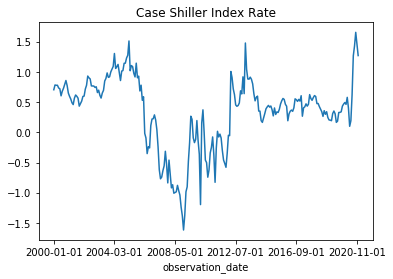

In [ ]:
data['label_case_shiller_rate'].plot()
plt.title("Case Shiller Index Rate")
plt.show()

## Section 1.3 : Finding correlation between features and label

In [ ]:
print("Correlation Coefficients -> ")
data.corr()['label_case_shiller_rate']

Correlation Coefficients -> 


d_house_affordability_index       -0.137610
d_consumer_sentiment               0.573332
d_consumer_price_index_rent       -0.065328
d_real_disposable_income          -0.047782
d_median_household_income          0.242709
d_mortgage_rates                  -0.034286
d_mortgage_rates_change            0.114586
d_new_house_sales                 -0.105275
d_existing_house_sales             0.699016
s_producer_price_index_material   -0.176368
s_new_houses_months_supply        -0.839231
s_existing_houses_months_supply   -0.825471
s_house_starts                     0.590292
s_employee_costs                   0.106906
label_case_shiller_rate            1.000000
Name: label_case_shiller_rate, dtype: float64

Here we find that the consumer sentiment (+ve), median household income (+ve), existing house sales (+ve), new houses monthly supply (-ve), existing houses monthly supply (-ve) and house starts (+ve) have a high magnitude of correlation with the case shiller index rate. We shall further test this heuristic with a simple OLS regression model.

# Section 2 : OLS Regression
## Section 2.1 : Normalizing data

In [ ]:
#in_max_scaler = MinMaxScaler()
#X_scaled = min_max_scaler.fit_transform(data.values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.values)
data_scaled = pd.DataFrame(X_scaled, index=data.index, columns=data.columns)
data_scaled.head(12)

,d_house_affordability_index,d_consumer_sentiment,d_consumer_price_index_rent,d_real_disposable_income,d_median_household_income,d_mortgage_rates,d_mortgage_rates_change,d_new_house_sales,d_existing_house_sales,s_producer_price_index_material,s_new_houses_months_supply,s_existing_houses_months_supply,s_house_starts,s_employee_costs,label_case_schiller_rate
observation_date,,,,,,,,,,,,,,,
2000-01-01,-0.857798,2.173462,-1.632342,-1.649020,0.349049,2.353745,1.093297,-0.000176,-0.109726,-1.522271,-0.587124,-0.686568,0.793795,-0.897899,0.605806
2000-02-01,-0.891037,2.115876,-1.623511,-1.628319,0.313212,2.444361,0.550947,-0.044513,-0.240323,-1.512229,-0.971173,-0.456250,1.013922,-0.876493,0.737736
2000-03-01,-0.946436,1.770357,-1.610265,-1.614382,0.277684,2.376399,-0.211262,-0.000176,-0.157216,-1.495491,-1.067186,-0.732631,0.724052,-0.814239,0.729192
2000-04-01,-0.983368,1.943117,-1.601434,-1.589190,0.242156,2.308437,-0.214800,-0.097718,-0.145343,-1.495491,-0.923167,-0.502313,0.772001,-0.855999,0.730625
2000-05-01,-1.097858,2.066516,-1.590395,-1.567788,0.206319,2.580286,1.437133,-0.071116,-0.252195,-1.528967,-0.875161,-0.502313,0.660848,-0.880108,0.655315
2000-06-01,-1.193882,1.712771,-1.577148,-1.554259,0.170482,2.414156,-0.662447,-0.017911,-0.228450,-1.522271,-0.731142,-0.456250,0.625976,-0.876026,0.631782
2000-07-01,-1.245588,1.869077,-1.561694,-1.526851,0.134954,2.308437,-0.393668,-0.088851,-0.252195,-1.539009,-0.875161,-0.502313,0.416746,-0.852258,0.436736
2000-08-01,-1.160643,1.786811,-1.546240,-1.496586,0.099426,2.217821,-0.328787,-0.062248,-0.180961,-1.562442,-0.827155,-0.456250,0.586745,-0.880166,0.564848
2000-09-01,-1.123711,1.745678,-1.532993,-1.495828,0.063589,2.127205,-0.335384,-0.079983,-0.038491,-1.559095,-0.731142,-0.594440,0.512643,-0.892522,0.646001


## Section 2.2 : Preliminary regression analysis
Here we observe that the features such as s_new_houses_months_supply, s_existing_houses_months_supply, d_house_affordability_index and d_median_household_income show the expected sign but a few new variables (such as s_employee_costs, s_producer_price_index_material) which showed low correlation have got relatively high magnitude coefficients. This is the first sign of discrepancy in the OLS Regression model. 

In [ ]:
# Preliminary Regression Analysis
lr_prelim = LinearRegression(fit_intercept=True)
X = data_scaled.loc[:, data_scaled.columns != 'label_case_shiller_rate'].to_numpy()
y = data_scaled.loc[:, data_scaled.columns == 'label_case_shiller_rate'].to_numpy()
lr_prelim.fit(X,y)
print("R^2 Score -> ",lr_prelim.score(X,y))
print("\nFeature Coefficients ->")
for feat, coef in zip(data_scaled.columns[:-1],list(lr_prelim.coef_)[0]):
    print(feat,coef,sep='\t')

R^2 Score ->  0.8513082019925762

Feature Coefficients ->
d_house_affordability_index	-0.17164085190436662
d_consumer_sentiment	0.025251094994930813
d_consumer_price_index_rent	-0.32644649869511017
d_real_disposable_income	-0.04560906436334289
d_median_household_income	0.2819256989734612
d_mortgage_rates	-0.38743943452306406
d_mortgage_rates_change	0.05634938829100972
d_new_house_sales	0.10968552725343383
d_existing_house_sales	0.35552018360686044
s_producer_price_index_material	0.31046877274225576
s_new_houses_months_supply	-0.2380095042684484
s_existing_houses_months_supply	-0.40781164173411816
s_house_starts	0.0767941447842397
s_employee_costs	-0.5835339007105108


## Section 2.3 : Preliminary feature importances
Taking note that some variables have high magnitude correlation coefficients with label_case_shiller_rate and regression coefficients while some others show discrepancies, the next step of preliminary analysis is done. Finding the R^2 score for the model by taking one feature at a time to find the representative power of each single feature. In actuality this test is done in the way where one feature is left out from the dataset and the R^2 score of the model is observed but this analysis did not give very useful results as the R^2 scores came out to be almost same. This shows us a second indication that the OLS Model is not capturing the real relation between features and variables and secondly that there is a high possibility that the features are correlated with each other.

In [ ]:
columns = data_scaled.columns[:-1] # Excluding label
r2_scores = []
for col in columns : 
    X_r2 = data_scaled[col].to_numpy().reshape(-1,1)
    lr_r2 = LinearRegression().fit(X_r2,y)
    r2_scores.append(lr_r2.score(X_r2,y))
df_r2scores=pd.DataFrame({"Feature":columns,"Importances (R^2 score)":r2_scores})
df_r2scores

,Feature,Importances (R^2 score)
0,d_house_affordability_index,0.018937
1,d_consumer_sentiment,0.328709
2,d_consumer_price_index_rent,0.004268
3,d_real_disposable_income,0.002283
4,d_median_household_income,0.058908
5,d_mortgage_rates,0.001176
6,d_mortgage_rates_change,0.013130
7,d_new_house_sales,0.011083
8,d_existing_house_sales,0.488623
9,s_producer_price_index_material,0.031106


Here we observe that variables such as s_new_houses_months_supply, s_existing_houses_months_supply, d_existing_house_sales, d_consumer_sentiment and s_house_starts show high representative power. Again this test is not very conclusive as it was performed differently from how it is normally used. This gives us indications that the underlying data is not stationary and that the OLS model cannot capture the time series data effectively. 

# Section 3 : Stationarity
## Section 3.1 Checking for Stationarity  
It is important to detrend the data to accurately capture the effect of the features under consideration on the label. By performing the Augmented Dickey-Fuller test and the KPSS test we can evaluate whether or not the data is stationary. A tolerance of 10% is used for both tests. Additionally the differenced values for each feature are used to check if differencing helps in detrending.  
Note - In all the plots in preprocessing.ipynb we can see that there are long-term trends to all of the features under consideration.

In [ ]:
result_dict = {}
columns = data_scaled.columns[:-1]
for col in columns :
    x = data_scaled[col].to_numpy()
    x_diff = (x[1:]-x[:-1])/x[:-1]
    result_adf = adfuller(x)
    result_adf_diff = adfuller(x_diff)
    result_kpss = kpss(x)
    result_kpss_diff = kpss(x_diff)
    result_dict[col] = {"ADF Test (original)" : result_adf[0] < result_adf[4]['10%'], "KPSS Test (original)" : result_kpss[0] < result_kpss[3]['10%'], "ADF Test (differencing)" : result_adf_diff[0] < result_adf_diff[4]['10%'], "KPSS Test (differencing)" : result_kpss_diff[0] < result_kpss_diff[3]['10%']}
pd.DataFrame(result_dict.values(), index=result_dict.keys())

,ADF Test (original),KPSS Test (original),ADF Test (differencing),KPSS Test (differencing)
d_house_affordability_index,False,False,True,True
d_consumer_sentiment,True,True,True,True
d_consumer_price_index_rent,False,False,True,True
d_real_disposable_income,False,False,True,True
d_median_household_income,False,False,True,True
d_mortgage_rates,False,False,True,True
d_mortgage_rates_change,True,True,True,True
d_new_house_sales,True,False,True,True
d_existing_house_sales,False,True,True,True
s_producer_price_index_material,False,False,True,True


As can be seen in the above table, most of the features fail either one or both tests of stationarity. We can see that the trend stationarity of these features can be removed by the method of differencing, i.e. taking differences in consecutive readings (degree of differencing = 1). However, the s_new_houses_months_supply fails the KPSS test even after differencing while the rest of the variables pass both tests.  
 
It is also important to note that there is some degree of seasonality in all the features (the housing market exhibits high seasonality, i.e. quarterly trends of supply and demand). Additionally, there are some trends which are caused by external factors such as the covid-19 pandemic and the 2008 crises. These trends are rather difficult to model quantitatively but their effect is very evident in the data. However, in the long-term, general trends help us model cumulative gains/losses over a longer period which are very important insights. The focal point of this analysis would be to capture long-term trends in the data.  

From the plot of differenced data for s_new_houses_months_supply below it is observed that there are some hints of non-stationarity due to the non-constant variance over the sample. The large peaks in months supply of new houses can be attributed to the build up of unsold new homes during the 2008 housing market crash.  

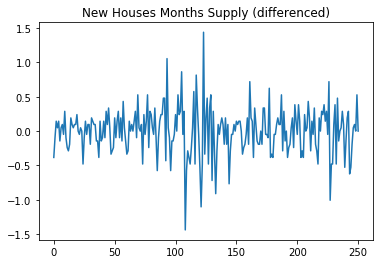

In [ ]:
plt.plot(np.array(data_scaled['s_new_houses_months_supply'].to_numpy()[1:]-data_scaled['s_new_houses_months_supply'].to_numpy()[:-1]))
plt.title("New Houses Months Supply (differenced)")
plt.show()

# Section 4 : Modelling and Feature Importance 
## Section 4.1 Model
Why not OLS?  
As was discussed in section 2, a simple regression analysis of the data helps us build a general heuristic about what features might be important in explaining the movement of the Case Shiller Index. However there is a big drawback that the simple OLS regression model performs poorly on time-series data especially one which is not stationary. As we observed above every feature under consideration is non-stationary.  

## ARIMA
Due to the drawbacks of OLS regression in modelling the data I have chosen the ARIMA (AutoRegressive Integrated Moving Average) framework. This model is good at modelling the mean non-stationarity of data which means that it would help us capture the underlying long-term trends that the features exhibit. In general it is good at modelling time series data when the features can be made stationary through differencing which was what we observed in section 3.  

The first step is to find the best hyperparameter setting (p,d,q) for the arima model. This exercise is done below where the model is fit onto 240 data points (20 years) of data and is then made to predict the final year's Case Shiller Index rate. The model which exhibits the least mean_squared_error in it's predictions is chosen.  

In [ ]:
p_values = [0,1,2,4,6,8,10]
d_values = range(0,3)
q_values = range(0,3)
result_dict = {}
for p in p_values: 
    for d in d_values:
        for q in q_values:
            predictions = []
            y_test = data_scaled['label_case_shiller_rate'][240:].to_list()
            for pnt in range(240,len(data_scaled['label_case_shiller_rate'])):
                X_train = data_scaled[data_scaled.columns[:-1]][:pnt]
                y_train = data_scaled['label_case_shiller_rate'][:pnt]                
                model = ARIMA(endog=y_train,order=(p,d,q),exog=X_train)
                model_fit = model.fit()
                y_hat = model_fit.predict()[0]
                predictions.append(y_hat)
            #print(predictions,y_test)
            result_dict[(p,d,q)] = mean_squared_error(predictions,y_test)
print(result_dict)

{(0, 0, 0): 0.894336274301973, (0, 0, 1): 0.8753403107396269, (0, 0, 2): 0.8654683020234363, (0, 1, 0): 1.2880315945977643, (0, 1, 1): 1.2100991914149717, (0, 1, 2): 1.0697173910509823, (0, 2, 0): 26.7147354661426, (0, 2, 1): 12.29727023219891, (0, 2, 2): 9.74032047849267, (1, 0, 0): 0.8337231227072003, (1, 0, 1): 0.833703240661457, (1, 0, 2): 0.8458619438662686, (1, 1, 0): 1.2490122571986484, (1, 1, 1): 0.8558069242771453, (1, 1, 2): 0.8940113912832022, (1, 2, 0): 34.10343117373712, (1, 2, 1): 10.52675264322379, (1, 2, 2): 11.74804612171544, (2, 0, 0): 0.8331719196642514, (2, 0, 1): 0.7380548113158271, (2, 0, 2): 0.8692387500907848, (2, 1, 0): 1.209264025920604, (2, 1, 1): 0.9003458512586722, (2, 1, 2): 0.860730239469147, (2, 2, 0): 32.51514137923451, (2, 2, 1): 12.29678126917806, (2, 2, 2): 11.074035759528087, (4, 0, 0): 0.8637047099734266, (4, 0, 1): 0.8384441693965311, (4, 0, 2): 0.8330395600180146, (4, 1, 0): 1.2720844098268675, (4, 1, 1): 1.2139810746653763, (4, 1, 2): 0.88208231

In [ ]:
min_mse=100
best_config=(0,0,0)
for key in result_dict.keys():
    if key[1]!=0 : 
        if result_dict[key]<min_mse:
            min_mse=result_dict[key]
            best_config=key
            
print("Best Config ->\n",best_config,min_mse)

Best Config ->
 (1, 1, 1) 0.8558069242771453


## Best Model
Here we see that the first order differenced Case Shiller Index Rate is necessary to fit a good model implying that the rate is largely dependent on historical rates.  
The first order difference in the input variables provides the best insight as expected from the Stationarity Test in section 3.
Number of lagged forecast errors is also of degree one.  
Hence,  
<b> best_p = 1 </b>  
<b> best_d = 1 </b>  
<b> best_q = 1 </b>

In [ ]:
arima = ARIMA(endog=data_scaled['label_case_shiller_rate'], order=(1,1,1), exog=data_scaled[data_scaled.columns[:-1]])
arima_fit = arima.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     label_case_schiller_rate   No. Observations:                  252
Model:                       ARIMA(1, 1, 1)   Log Likelihood                 -61.970
Date:                      Sat, 03 Apr 2021   AIC                            157.941
Time:                              13:42:17   BIC                            217.874
Sample:                          01-01-2000   HQIC                           182.059
                               - 12-01-2020                                         
Covariance Type:                        opg                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
d_house_affordability_index        -0.2345      0.143     -1.637      0.102      -0.515       0.046
d_consumer_sentiment                0.0334      0.072      0.461      0.644      -0.108       0.175
d_consumer_price_index_rent        -0.5193      0.553     -0.939      0.348      -1.603       0.564
d_real_disposable_income            0.0314      0.274      0.115      0.909      -0.505       0.568
d_median_household_income           0.2476      0.276      0.898      0.369      -0.293       0.788
d_mortgage_rates                   -0.4393      0.226     -1.946      0.052      -0.882       0.003
d_mortgage_rates_change             0.0576      0.028      2.078      0.038       0.003       0.112
d_new_house_sales                  -0.0751      0.276     -0.272      0.785      -0.615       0.465
d_existing_house_sales              0.2735      0.117      2.330      0.020       0.043       0.504
s_producer_price_index_material     0.2057      0.338      0.609      0.543      -0.457       0.868
s_new_houses_months_supply         -0.2235      0.074     -3.033      0.002      -0.368      -0.079
s_existing_houses_months_supply    -0.3813      0.111     -3.437      0.001      -0.599      -0.164
s_house_starts                      0.0332      0.119      0.279      0.780      -0.200       0.266
s_employee_costs                   -0.3146      0.336     -0.937      0.349      -0.973       0.344
ar.L1                               0.6397      0.059     10.924      0.000       0.525       0.755
ma.L1                              -0.9946      0.087    -11.405      0.000      -1.165      -0.824
sigma2                              0.0948      0.010      9.891      0.000       0.076       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               348.08
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.70
Prob(H) (two-sided):                  0.87   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Section 4.2 Important Variables
From the above table, looking at the p values, we collect all variables which are significant and have large regression coefficients. Taking 10% significance threshold.

In [ ]:
imp_variables = {"Variables":['d_house_affordability_index','d_mortgage_rates','d_existing_house_sales','s_new_houses_months_supply','s_existing_houses_months_supply'],"P value":[0.102,0.052,0.020,0.002,0.001], "Coefficient":[-0.2345,-0.4393,0.2735,-0.2235,-0.3813]}
imp_vars_df = pd.DataFrame(imp_variables)
imp_vars_df.set_index(['Variables'],inplace=True)
imp_vars_df.head()

,P value,Coefficient
Variables,,
d_house_affordability_index,0.102,-0.2345
d_mortgage_rates,0.052,-0.4393
d_existing_house_sales,0.020,0.2735
s_new_houses_months_supply,0.002,-0.2235
s_existing_houses_months_supply,0.001,-0.3813


# Section 5 : Causality Tests
## Section 5.1 : Granger Causality Analysis results
Here the granger causality of variables is analysed to asses whether the features contribute towards changes in the Case Shiller Index or if they are a product of changes in the Index. Lag periods of a month (1) and a quarter (4) are used.

In [ ]:
gct = list(imp_vars_df.index)
label = "label_case_shiller_rate"
lags = [1,4]
null_hyps = []
p_vals = []
for lag in lags:
    for feature in gct:
        null_hypothesis_feat = feature+" does not cause change in "+label + " lag:"+str(lag)
        null_hypothesis_label = label+" does not cause change in "+feature + " lag:"+str(lag)
        null_hyps.extend([null_hypothesis_feat,null_hypothesis_label])
        gc_res_feat = grangercausalitytests(data_scaled[[label,feature]], [lag],verbose=0) # Feature does not cause label
        gc_res_label = grangercausalitytests(data_scaled[[feature,label]], [lag],verbose=0) # Label does not cause feature
        p_vals.append(gc_res_feat[lag][0]['ssr_ftest'][1])
        p_vals.append(gc_res_label[lag][0]['ssr_ftest'][1])
pd.set_option('display.max_colwidth', None)
gct_df = pd.DataFrame({"Null Hypotheses":null_hyps,"P Values":p_vals})
gct_df["Reject"] = gct_df['P Values']>=0.05
gct_df

,Null Hypotheses,P Values,Reject
0,d_house_affordability_index does not cause change in label_case_schiller_rate lag:1,0.074895,True
1,label_case_schiller_rate does not cause change in d_house_affordability_index lag:1,0.001294,False
2,d_mortgage_rates does not cause change in label_case_schiller_rate lag:1,0.142954,True
3,label_case_schiller_rate does not cause change in d_mortgage_rates lag:1,0.173098,True
4,d_existing_house_sales does not cause change in label_case_schiller_rate lag:1,0.364968,True
5,label_case_schiller_rate does not cause change in d_existing_house_sales lag:1,0.003377,False
6,s_new_houses_months_supply does not cause change in label_case_schiller_rate lag:1,0.000002,False
7,label_case_schiller_rate does not cause change in s_new_houses_months_supply lag:1,0.067960,True
8,s_existing_houses_months_supply does not cause change in label_case_schiller_rate lag:1,0.000209,False
9,label_case_schiller_rate does not cause change in s_existing_houses_months_supply lag:1,0.157116,True



The significant variables got from the ARIMA model are put through the granger causality test to check whether the direction of causality that is assumed while modelling holds true. The following results were obtained. Note - Case Shiller Index Rate = CSIR, significance = 0.05  
- New Houses monthly supply granger causes changes in CSIR over lag period 1
- Existing Houses monthly supply granger causes changes in CSIR over lag period 1
- House affordability index causes changes in CSIR over lag period 4
- Existing houses sales figures causes changes in CSIR over lag period 4
- Mortgage rates do not cause changes in CSIR over either lag period but if significance is increased, it exerts changes in CSIR over a lag period of 4.

# Section 6 : Conclusions
The approach to this analysis was based of the report that was submitted (Task 1) and articles/reports/research papers on supply demand modelling of the housing market. There is a large amount of personal bias in the selection of variables for supply and demand which leads to some unexpected results but in general the model gives a fairly good surface level representation of the market.
## Section 6.1 : Insights
The demand factors which affect residential prices are - 
- House Affordability Index 
- Existing House sales 
- Mortgage Rates   

The supply factors influencing residential prices are - 
- New houses months supply
- Existing houses months supply

## Section 6.2 : Discrepancies 
1. I expected New House Sales figures to drive prices to a larger extent as vacant home owners are much more incentivized to find a buyer sooner than sellers who reside in the homes that are put up for sale. Yet this feature was not significant in the model.
2. The demand factors exerted strong granger causality on the Case Shiller Index over a quarterly period whereas the supply factors showed granger causality over a monthly period. This goes against the general heuristic that the supply in the housing industry is less elastic than the demand. It is believed that the supply lags by a quarter to 6 months in its response to market changes whereas demands are more or less instantaneous (subject to seasonality).

## Section 6.3 : Room for Improvement
1. Use housing market related data extending up to a larger time period.
2. Try modelling demographic changes, market abnormalities and secondary market influences on the housing market. This might give a more complete view of the market.

# Section 7 : Sources
Data sources listed in preprocessing.ipynb
1. Supply Demand Modelling - https://www.centralbank.ie/docs/default-source/publications/research-technical-papers/research-technical-paper-08rt12.pdf?sfvrsn=8
2. ARIMA - https://people.duke.edu/~rnau/411arim.htm#:~:text=A%20nonseasonal%20ARIMA%20model%20is,errors%20in%20the%20prediction%20equation. ; https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ ; https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965 ; https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
3. Granger Causality Test - https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6 ; https://en.wikipedia.org/wiki/Granger_causality
4. Stationarity - https://machinelearningmastery.com/time-series-data-stationary-python/ ; https://machinelearningmastery.com/time-series-trends-in-python/#:~:text=Removing%20a%20Trend&text=Once%20modeled%2C%20it%20can%20be,said%20to%20be%20trend%20stationary.